In [71]:
import pandas as pd
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

In [7]:
df = yf.download("CAD=X", start="1990-01-01", interval="1d", auto_adjust = True)
df

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,CAD=X,CAD=X,CAD=X,CAD=X,CAD=X
Date,,,,,
2003-09-17,1.36670,1.37040,1.36360,1.36670,0
2003-09-18,1.36150,1.36850,1.35970,1.36600,0
2003-09-19,1.34720,1.36300,1.34570,1.36200,0
2003-09-22,1.35420,1.35530,1.33650,1.34130,0
2003-09-23,1.35510,1.35770,1.34580,1.35490,0
...,...,...,...,...,...
2025-11-13,1.40093,1.40160,1.39851,1.40093,0
2025-11-14,1.40355,1.40447,1.40148,1.40364,0


In [21]:
p = df['Close']
p = p[(p.index >= "2007-07-22") & (p.index < "2012-03-29")]


<Axes: xlabel='Date'>

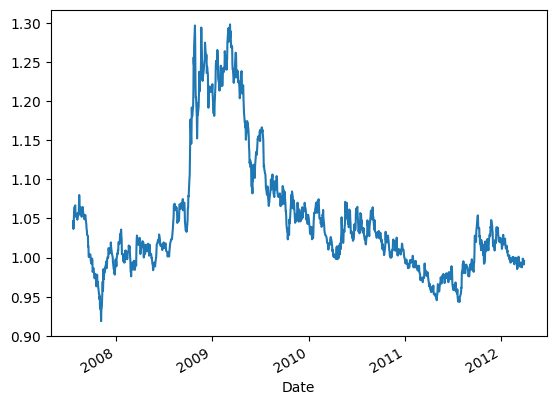

In [46]:
s = p['CAD=X']
s.plot()

In [23]:
adfuller(p)

(np.float64(-1.5638646189213663),
 np.float64(0.5017156178127697),
 18,
 1197,
 {'1%': np.float64(-3.4358248361156765),
  '5%': np.float64(-2.8639575982634757),
  '10%': np.float64(-2.5680571735171958)},
 np.float64(-7964.428150553727))

In [50]:
import numpy as np
from scipy.stats import linregress

def genhurst_python(series, q=2, min_lag=1, max_lag=None):
    """
    Compute generalized Hurst exponent H(q) matching MATLAB genhurst.
    
    Parameters
    ----------
    series : array-like
        Log-price series (or any time series).
    q : float
        Moment order. Use q=2 for standard Hurst exponent.
    min_lag : int
        Minimum lag τ.
    max_lag : int or None
        Maximum lag τ. If None, uses len(series)//10.
    """
    
    x = np.asarray(series)
    x = x[~np.isnan(x)]
    
    if max_lag is None:
        max_lag = len(x) // 10
        
    # Define lags (MATLAB uses ~50 points)
    lags = np.unique(np.logspace(
        np.log10(min_lag),
        np.log10(max_lag),
        num=50
    ).astype(int))
    
    moments = []
    
    for tau in lags:
        diffs = np.abs(x[tau:] - x[:-tau]) ** q
        moments.append(np.mean(diffs))
    
    log_tau = np.log(lags)
    log_mom = np.log(moments)
    
    # Fit: log M(q,tau) = a + 2H(q) * log(tau)
    slope, intercept, *_ = linregress(log_tau, log_mom)
    
    Hq = slope / (2.0)   # divide by q? NO. MATLAB genhurst divides by 2 for q=2 case.
    
    return Hq, {"lags": lags, "log_tau": log_tau, "log_mom": log_mom}

logy = np.log(s)

H, info = genhurst_python(logy, q=2)
print("H =", H)

H = 0.46667360275230796


In [62]:
from arch.unitroot import VarianceRatio

vr = VarianceRatio(s, 10)
print(vr.summary().as_text())

     Variance-Ratio Test Results     
Test Statistic                  0.052
P-value                         0.959
Lags                               10
-------------------------------------

Computed with overlapping blocks (de-biased)


In [80]:
y = s.copy()
ylag = y.shift()
delta = y - ylag
delta = delta[1:]
ylag = ylag[1:]
X = np.column_stack([ylag, np.ones_like(ylag)])
X = sm.add_constant(ylag)
model = sm.OLS(delta, X).fit()
beta = model.params[0]
halflife = -np.log(2) / beta
halflife


/var/folders/bc/hnzwjdn546lcc572zg36k_vc0000gn/T/ipykernel_97724/1889873494.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[0]


np.float64(-118.83985088167488)

# Cointegration

In [81]:
df = yf.download(["EWC", "EWA"], start="2006-04-04", end="2012-04-09", auto_adjust = True)
df

[*********************100%***********************]  2 of 2 completed


Price           Close                  High                   Low             \
Ticker            EWA        EWC        EWA        EWC        EWA        EWC   
Date                                                                           
2006-04-04   8.515041  16.175814   8.548483  16.223231   8.443978  16.060659   
2006-04-05   8.661345  16.338383   8.707328  16.392573   8.573562  16.189359   
2006-04-06   8.770031  16.534821   8.782572  16.582237   8.715689  16.379024   
2006-04-07   8.690609  16.426443   8.770032  16.629656   8.640446  16.412895   
2006-04-10   8.669705  16.494177   8.703147  16.589009   8.627903  16.426439   
...               ...        ...        ...        ...        ...        ...   
2012-03-30  12.906742  21.190882  12.928701  21.295565  12.824394  21.078721   
2012-04-02  12.972620  21.534838  13.033009  21.587181  12.813414  21.138538   
2012-04-03  12.769496  21.213314  12.879293  21.527364  12.681658  21.116107   
2012-04-04  12.615780  20.839447  12.681659  21.033858  12.566371  20.689899   
2012-04-05  12.692639  20.719805  12.736558  20.891785  12.632250  20.630077   

Price            Open              Volume           
Ticker            EWA        EWC      EWA      EWC  
Date                                                
2006-04-04   8.443978  16.148719   336600   874700  
2006-04-05   8.623724  16.189359   301800   457500  
2006-04-06   8.770031  16.453536   193200   530100  
2006-04-07   8.740771  16.595788   450100  1058500  
2006-04-10   8.694786  16.561915   260100   691300  
...               ...        ...      ...      ...  
2012-03-30  12.912232  21.243223  2442700  1208700  
2012-04-02  12.846353  21.168447  1962000  1644300  
2012-04-03  12.873804  21.460067  3390000  1406800  
2012-04-04  12.643230  20.981516  3739000  1967000  
2012-04-05  12.632250  20.831967  2165600  1267400  

[1514 rows x 10 columns]

<Axes: xlabel='Date'>

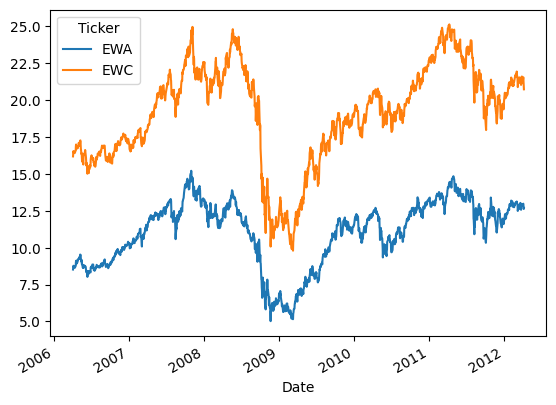

In [83]:
close = df['Close']
close.plot()

In [118]:
x = close['EWA']
y = close['EWC']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
model.params

const    3.155010
EWA      1.447694
dtype: float64

<Axes: xlabel='Date'>

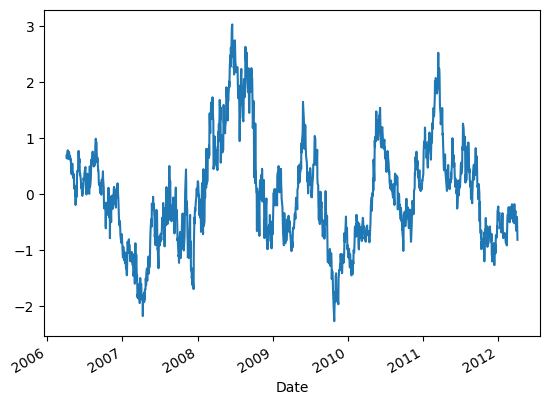

In [119]:
model.resid.plot()

In [127]:
from statsmodels.tsa.stattools import coint

x = close['EWA']

stat, pval, crit = coint(y, x, trend="c", maxlag = 1, autolag = None)

print("Engle–Granger CADF via coint")
print("stat:", stat)
print("p-value:", pval)
print("crit:", crit)

Engle–Granger CADF via coint
stat: -3.6753083921219245
p-value: 0.019708215572747215
crit: [-3.90369318 -3.34017138 -3.04725436]


In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

jres = coint_johansen(close, det_order = 0, k_ar_diff = 1)

print("Trace statistics:", jres.trace_stat)
print("Trace crit values (90,95,99%):\n", jres.trace_stat_crit_vals)

print("Max-eig statistics:", jres.max_eig_stat)
print("Max-eig crit values (90,95,99%):\n", jres.max_eig_stat_crit_vals)

Trace statistics: [20.54696638  4.11775997]
Trace crit values (90,95,99%):
 [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Max-eig statistics: [16.4292064   4.11775997]
Max-eig crit values (90,95,99%):
 [[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


In [3]:
df = yf.download(["EWC", "EWA", "IGE"], start="2006-04-04", end="2012-04-09", auto_adjust = True)
df = df['Close']
df

[*********************100%***********************]  3 of 3 completed


Ticker,EWA,EWC,IGE
Date,,,
2006-04-04,8.515039,16.175812,21.062279
2006-04-05,8.661348,16.338387,21.412416
2006-04-06,8.770032,16.534819,21.505354
2006-04-07,8.690608,16.426437,21.243832
2006-04-10,8.669707,16.494181,21.568037
...,...,...,...
2012-03-30,12.906745,21.190880,27.404095
2012-04-02,12.972620,21.534840,27.723883
2012-04-03,12.769495,21.213310,27.445805


In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

jres = coint_johansen(df, det_order = 0, k_ar_diff = 1)

print("Trace statistics:", jres.trace_stat)
print("Trace crit values (90,95,99%):\n", jres.trace_stat_crit_vals)

print("Max-eig statistics:", jres.max_eig_stat)
print("Max-eig crit values (90,95,99%):\n", jres.max_eig_stat_crit_vals)

Trace statistics: [35.21766775 17.15573578  4.58885265]
Trace crit values (90,95,99%):
 [[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Max-eig statistics: [18.06193197 12.56688313  4.58885265]
Max-eig crit values (90,95,99%):
 [[18.8928 21.1314 25.865 ]
 [12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


In [7]:
jres.eig

array([0.01187466, 0.00827699, 0.00303035])

In [8]:
jres.evec

array([[ 1.6554114 , -0.28463047,  0.10717238],
       [-1.53419503, -0.70686652,  0.43836397],
       [ 0.3699671 ,  0.74651221, -0.16722705]])

In [29]:
shares = jres.evec[:, 0]
y3 = df.values
yport = y3 @ shares
yport = pd.Series(yport, index = df.index)


ylag = yport.shift(1)
deltaY = yport - ylag

deltaY = deltaY[1:]
ylag = ylag[1:]

x = sm.add_constant(ylag)

model = sm.OLS(deltaY, x).fit()
beta = model.params[0]

halflife = -np.log(2) / beta
halflife

np.float64(21.490941696010946)

## Kalman Filter

In [138]:
x = df["EWA"]
y = df["EWC"]
x = np.column_stack([x, np.ones(len(x))])
delta = 0.0001
y_hat = np.full(len(x), np.nan)
e = np.full(len(x), np.nan)
Q = np.full(len(x), np.nan)

In [139]:
P = np.zeros((2, 2))
beta = np.full((2, len(x)), np.nan)
Vw = delta / (1 - delta) * np.diag(np.ones(2))
Ve = 0.001

In [140]:
y_hat

array([nan, nan, nan, ..., nan, nan, nan], shape=(1514,))

In [141]:
beta[:, 0] = 1

for i in range(1, len(x)):
    
    beta[:, i] = beta[:, i - 1]
    R = P + Vw
    
    x_t = x[i, :]
    x_t = x_t.reshape(-1, 1)
    
    beta_t = beta[:, i]
    beta_t = beta_t.reshape(-1, 1)
    
    y_hat[i] = x_t.T @ beta_t

    Q[i] = x_t.T @ R @ x_t + Ve

    e[i] = y[i] - y_hat[i]

    K = R @ x_t / Q[i]
    
    beta[:, i] = (beta_t + K * e[i]).reshape(-1)
    
    P = R - K @ x_t.T @ R

/var/folders/bc/hnzwjdn546lcc572zg36k_vc0000gn/T/ipykernel_13814/2480136670.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_hat[i] = x_t.T @ beta_t
/var/folders/bc/hnzwjdn546lcc572zg36k_vc0000gn/T/ipykernel_13814/2480136670.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q[i] = x_t.T @ R @ x_t + Ve
/var/folders/bc/hnzwjdn546lcc572zg36k_vc0000gn/T/ipykernel_13814/2480136670.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  e[i] = y[i] - y_h

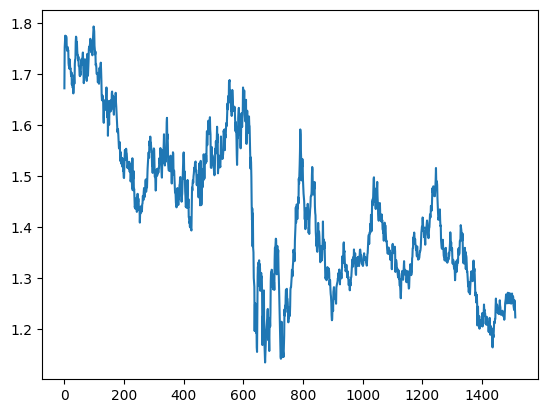

In [142]:
plt.plot(beta[0, 1:])

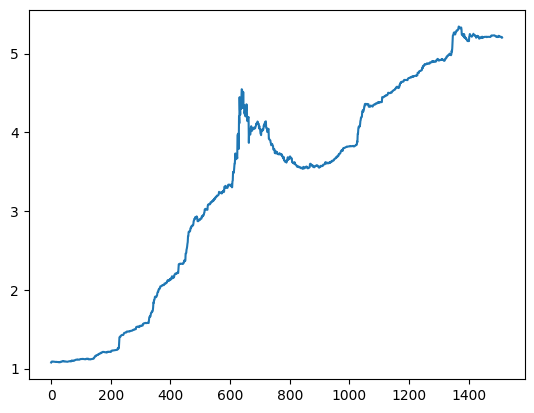

In [143]:
plt.plot(beta[1, 1:])

In [76]:
beta

array([[-0.25702889, -0.17893253, -0.14619693, ...,  1.17174361,
         1.15770361,  1.14115686],
       [17.49987365, 17.77515009, 17.78307439, ...,  6.25447203,
         6.24511456,  6.2475973 ]], shape=(2, 1514))